In [1]:
import autograd.numpy as np
from autograd.numpy import linalg
from autograd.numpy.random import poisson, normal, multivariate_normal
from autograd import grad
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
import emcee as mc
import george as ge
from george.metrics import Metric

def neg_log_like_PGP(mu, s, ni, y, cov, debug, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    det = linalg.det(cov)
    t1 = -(N/2.)*np.log(2.*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (y-mu)[np.newaxis]
    t2 = (-(1./2) * np.dot(np.dot(resid,invcov),resid.T))[0][0]
    t3 = np.sum(ni * np.log(mu + s) - (mu + s))
    result =  t2 + t3 + t1 #t1 breaks it for some reason
    if debug:
        print ("t1: " + str(t1) + "\tt2: " + str(t2) + "\tt3: " + str(t3))
    if not(np.isfinite(result)):
        print "Is $\infty$"
        return np.infty
    if np.isnan(result):
        print("Is NaN: \tt2 = " +str(t2) + "\tt3: " + str(t3) + "\tresult: " + str(result))
    else:
        return -result               
    
neg_log_like_PGP_grad = grad(neg_log_like_PGP)


def true_mu(x):
    return (1./np.log(x+1))

def y_model(x):
    return 1./(np.power(x+.3,2))

def y_opt(x, params):
    a, b, c, d = params
    return ((1.*a)/(np.power(b*x + c,2)))+d

def y_preopt(x, a, b, c, d):
        params = np.array([a,b,c,d])
        return y_opt(x, params)
    
class mean_model(object):
    def __init__(self, f, params):
        self.f = f
        self.params = params
        self.frozen = True
    def get_value(self, x):
        return self.f(x, self.params)
    def freeze_all_parameters(self):
        self.frozen = True


def kernel_func_exp(x1,x2, params):
    A = params[0]
    l = params[1]

    result = A * np.exp(-np.power((x1-x2),2)/(l**2))
    return result

def kernel_func_gibbs(x1,x2, params):
    A = params[0]
    a = params[1]
    b = params[2]
    c = params[3]
    d = params[4]
    result = A * np.exp(-(((x1-x2)**2)/(((b*x1 + c)**2)+((b*x2 + c)**2)))+((d-(x1+x2))/(2.*a)))
    return result

#expkernel = ge.kernels.PythonKernel(kernel_func_exp, pars= [5., .5])

def make_kernel(x, k, params):
    N = len(x)
    cov = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    return cov

def predict(t, n, y, cov, sigma):
    N = len(t)
    p_dist = np.empty(N)
    v_dist = np.empty(N)
    for i in range(N):
        inv = linalg.inv(cov+np.diag(np.power(sigma,2)))
        p_dist[i] = y[i] + cov[i].T.dot(inv.dot(n-y))
        v_dist[i] = cov[i][i] - cov[i].T.dot(inv.dot(cov[i]))
    return p_dist, v_dist
            


In [2]:
#initialization
N = 30
scale = 100.
params_test = [10*scale, 6., .3, 0.]
t = np.linspace(1, 10,N)
mu_test = scale* true_mu(t)

#generating poisson distributed data
n_test = poisson(mu_test)
n_err = np.sqrt(n_test)

#optimizing model parameters
popt, pcov = curve_fit(y_preopt, t, n_test, p0=[params_test])
params_test = popt
model_test = y_opt(t, params_test)
s_test = np.zeros(N)
#boundarray = [(n_test[i]-np.sqrt(n_test[i]),n_test[i]+np.sqrt(n_test[i])) for i in range(N)]
boundarray = [(1,None) for i in range(N)]

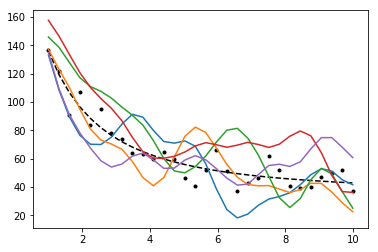

In [8]:
cov_PGP = make_kernel(t, kernel_func_exp, [scale*3., 1.])
#cov_PGP = make_kernel(t, kernel_func_gibbs, [5., 1., 1., 0., 10.])
plt.plot(t, n_test, 'k.', label = "counts")
plt.plot(t, model_test,'k--', label = "Mean")
for i in range(5):
    sample = np.random.multivariate_normal(model_test, cov_PGP)
    plt.plot(t, sample)
    
plt.show()
#n_test = sample

In [9]:
pred, pred_var = predict(t, n_test, model_test, cov_PGP, np.sqrt(n_test))
pred_unc = np.sqrt(pred_var)

In [13]:
#PGP fit
#def neg_log_like_PGP(mu, s, ni, y, cov, invcov = None)
options={'ftol' :  np.finfo(float).eps, 'maxfun': 1.5e5, 'maxiter': 1.5e5, 'gtol': np.finfo(float).eps}
soln_PGP = minimize(neg_log_like_PGP, model_test, jac = neg_log_like_PGP_grad,  method="L-BFGS-B", args = (s_test, n_test, model_test, cov_PGP, False), options = options, bounds = boundarray)

#soln_PGP = minimize(neg_log_like_PGP, pred,  method="TNC", args = (s_test, n_test, model_test, cov_PGP),  bounds = boundarray)

PGP_fit = soln_PGP.x
PGP_fit_unc = (np.diag(soln_PGP.hess_inv.matmat(np.eye(N))))
print soln_PGP



      fun: -6094.797792955898
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00038486,  0.003119  ,  0.00077175, -0.0026263 , -0.00011441,
        0.0031442 , -0.00725397,  0.00518229, -0.00150934, -0.00309035,
        0.00692262, -0.01061876,  0.01266623, -0.01218854,  0.00969104,
       -0.00804956,  0.00591948, -0.00388884,  0.00235275, -0.00192372,
        0.00093931,  0.00022157,  0.0005246 , -0.00264493,  0.00319722,
       -0.00100164, -0.00210158,  0.00393063, -0.00299579,  0.00094491])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 15476
      nit: 13530
   status: 2
  success: False
        x: array([135.60274435, 117.17793109, 104.30113951,  96.57380449,
        91.84095278,  86.98313049,  80.14888849,  72.26160586,
        66.15256227,  63.63718437,  63.09581155,  60.67113828,
        54.86645375,  49.25068701,  48.58764668,  52.23276579,
        54.04307741,  50.15963561,  44.41806217,  43.55826647,
        48.428904  ,  52.82047804,

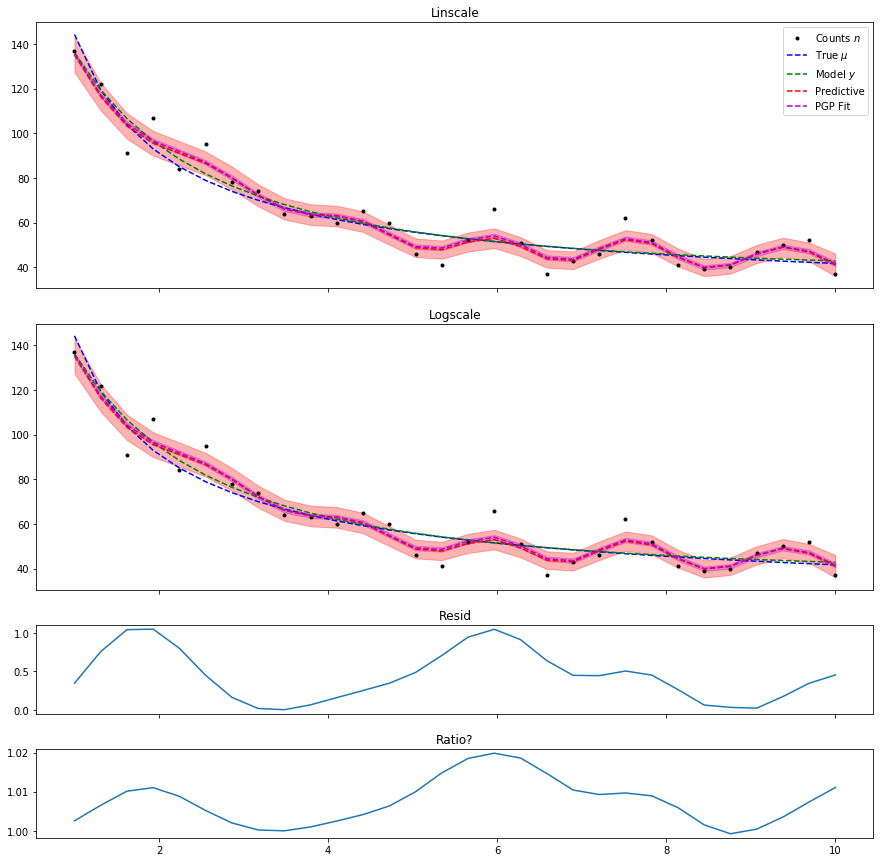

In [37]:
#sanitize lowbound for logscale plotting
from matplotlib import gridspec
PGP_low = PGP_fit-PGP_fit_unc
pred_low = pred-pred_unc
pred_limit = pred
lowbound = 1e-1

sanitize = [PGP_low,pred_low]
for y in sanitize:
    for i in range(N):
        if y[i]<lowbound:
            y[i] = lowbound
   

#plotting results
PGP_fill = (PGP_fit + PGP_fit_unc, PGP_fit - PGP_fit_unc)
PGP_fill_log =  (PGP_fit + PGP_fit_unc, PGP_low)
pred_fill = (pred + pred_unc, pred - pred_unc)
pred_fill_log = (pred + pred_unc, pred_low)

plot = [n_test, mu_test, model_test, pred_limit, PGP_fit]
fmt = ['k.', 'b--', 'g--', 'r--', 'm--']
fill = [None, None, None, 'r',  'm']
labels = ["Counts $n$", "True $\mu$", "Model $y$", "Predictive", "PGP Fit"]
fill_bounds = [None, None, None, pred_fill,PGP_fill]
fill_bounds_log = [None, None, None, pred_fill, PGP_fill_log]



fig, ax = plt.subplots(nrows = 4, ncols = 1, sharex=True, gridspec_kw={'height_ratios': [3, 3, 1,1]}, figsize=(15,15))
for i in range(len(plot)):
    ax[0].plot(t, plot[i], fmt[i], label = labels[i])
    ax[1].plot(t, plot[i], fmt[i], label = labels[i])
    if fill[i]!=None:
        ax[0].fill_between(t, fill_bounds[i][0], fill_bounds[i][1], color=fill[i], alpha=0.3, edgecolor='none')
        ax[1].fill_between(t, fill_bounds[i][0], fill_bounds[i][1], color=fill[i], alpha=0.3, edgecolor='none')

ax[2].plot(t, np.abs(PGP_fit-pred), label = "Residual")
ax[3].plot(t, np.abs(PGP_fit/pred), label = "Ratio?")
ax[0].legend(loc="upper right")

ax[0].set_title("Linscale")
ax[1].set_title("Logscale")
ax[2].set_title("Resid")
ax[3].set_title("Ratio?")

plt.show()

In [12]:
print pred-PGP_fit

[-0.30893588 -0.72654947 -1.04104774 -1.06900556 -0.81524678 -0.45677529
 -0.17479299 -0.03331903 -0.00641597 -0.05732244 -0.15562222 -0.26262074
 -0.36204211 -0.49696993 -0.71632994 -0.96369297 -1.072533   -0.93243693
 -0.64490994 -0.4438721  -0.44102542 -0.51045809 -0.46081942 -0.26156437
 -0.04866245  0.03903499 -0.02973663 -0.19070309 -0.3442649  -0.41184245]
